In [ ]:
#comparing a neural network and a simple logistic regression model for the famous heart disease dataset

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset,DataLoader
import torch.optim as optim

In [2]:
#setting up datasets and dataloaders
df = pd.read_csv('heart.csv')

x = df.drop(columns=['target'])
y = df['target']

x = np.array(x,dtype=np.float32)
y = np.array(y)

#splitting datasets for learning
X_train, X_test, Y_train, Y_test = train_test_split(x,y,test_size=0.2,random_state=42)

scaler = StandardScaler()

#normalizing data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.tensor(X_train)
Y_train = torch.tensor(Y_train)
X_test = torch.tensor(X_test)
Y_test = torch.tensor(Y_test)

#dataloaders and datasets
training_dataset = TensorDataset(X_train,Y_train)
training_dataloader = DataLoader(training_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test,Y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [6]:
#neural network defination
class network(nn.Module):

    def __init__(self,input):
        super().__init__()
        self.layer1=nn.Linear(input,7)
        self.layer2=nn.Linear(7,3)
        self.layer3=nn.Linear(3,1)

    def forward(self,X):
        out = F.relu(self.layer1(X))
        out = F.relu(self.layer2(out))
        return self.layer3(out)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = network(13).to(device)

#hyperparameters
n_epochs = 1000
learning_rate = 0.001

loss = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)

For Epoch 100: Loss = 0.24162862795155224
For Epoch 200: Loss = 0.1616607161556802
For Epoch 300: Loss = 0.11734575919988678
For Epoch 400: Loss = 0.0804121666565174
For Epoch 500: Loss = 0.058766542883907875
For Epoch 600: Loss = 0.04298180149095814
For Epoch 700: Loss = 0.03619751207439638
For Epoch 800: Loss = 0.02927561517032545
For Epoch 900: Loss = 0.02921252737230644
For Epoch 1000: Loss = 0.027998460374954272


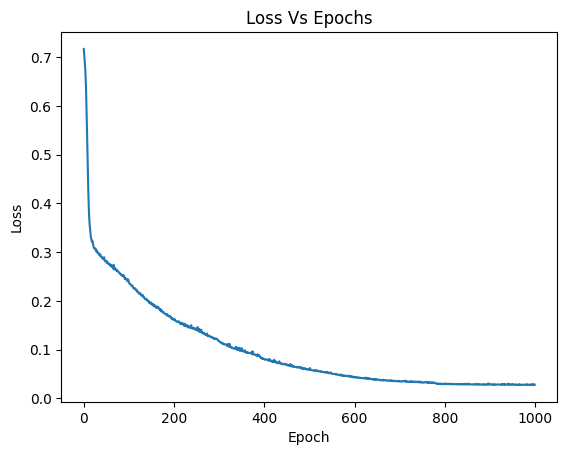

In [7]:
#training loop
graph = {}

for epoch in range(n_epochs):

    total_loss = 0

    for batch_x,batch_y in training_dataloader:

        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        y_hat = model(batch_x)

        l = loss(y_hat.squeeze(), batch_y.float())
        l.backward()

        total_loss += l.item() * training_dataloader.batch_size

        optimizer.step()

        optimizer.zero_grad()

    avg_loss = total_loss / len(training_dataloader.dataset)

    graph[epoch] = avg_loss

    if (epoch+1)%100==0:
        print(f'For Epoch {epoch+1}: Loss = {avg_loss}')

#graph
plt.title('Loss Vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(graph.keys(),graph.values())

In [8]:
#model evaluation
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch_x, batch_y in test_dataloader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        outputs = model(batch_x)
        probs = torch.sigmoid(outputs).squeeze()
        preds = (probs > 0.5).long()

        correct += (preds == batch_y).sum().item()
        total += batch_y.size(0)

accuracy = correct / total
print(f"Test Accuracy: {accuracy*100:.2f}%")

Test Accuracy: 98.54%


In [9]:
#simple logistic regression model
from sklearn.linear_model import LogisticRegression

In [10]:
x = df.drop(columns=['target'])
y = df['target']

x = np.array(x,dtype=np.float32)
y = np.array(y)

#splitting datasets for learning
X_train, X_test, Y_train, Y_test = train_test_split(x,y,test_size=0.2,random_state=42)

scaler = StandardScaler()

#normalizing data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
#fitting the model
model = LogisticRegression(random_state=42)

model.fit(X_train,Y_train)

LogisticRegression(random_state=42)

In [12]:
#checking the accuracy
from sklearn.metrics import accuracy_score

y_hat = model.predict(X_test)

accuracy = accuracy_score(Y_test, y_hat)
error = 1 - accuracy
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Error Rate: {error*100:.2f}%")

Accuracy: 79.51%
Error Rate: 20.49%


In [13]:
#linear features are resulting in high bias, let's try polynomial ones
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_train = poly.fit_transform(X_train)
X_test = poly.transform(X_test)

model.fit(X_train, Y_train)

LogisticRegression(random_state=42)

In [14]:
#model evaluation for polynomial features
y_hat = model.predict(X_test)

accuracy = accuracy_score(Y_test, y_hat)
error = 1 - accuracy
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Error Rate: {error*100:.2f}%")

Accuracy: 93.66%
Error Rate: 6.34%


In [ ]:
#conclusion

#on an earlier attempt, i got logisitic regression to give the same accuracy as the neural network with 2 polynomials
#i don't know why it's not giving me the same error now, but from what i've concluded, a logistic regression model would be better
#for this data as it's a simpler model giving you the same results with a smaller inference time and less memory usage